# Self-Driving Car Engineer Nanodegree

---
## Step 0: The Project Classes

### 0.1 Image Manipulation Toolkit

In [1]:
import cv2
from sklearn.utils import shuffle
import random as rand
import numpy as np

    
class SelectionTools():
        
    def sample(self, data, label):
        return np.concatenate([data, data]), np.concatenate([label, label])
        
    def normalize(self, data):
        
        output = np.copy(data).astype(float)
        
        for i, image in enumerate(data):
            cv2.normalize(image.astype(float), output[i], -1, 1, cv2.NORM_MINMAX)

        return output
        
        
    def grayscale(self, data):
        return np.sum(data/6, axis=3, keepdims=True)
    
    def brightness(self, data):
        
        output = np.copy(data)
        
        for i, img in enumerate(data):
            shifted = img + 1.0   # shift to (0,2) range
            img_max_value = max(shifted.flatten())
            max_coef = 2.0/img_max_value
            min_coef = max_coef - 0.1
            coef = np.random.uniform(min_coef, max_coef)
            output[i] = shifted * coef - 1.0
            
        return output
    
    def level(self, data, label, limit):
        
        # Get number of classes.
        data_ = np.copy(data)
        label_ = np.copy(label)
        n_classes = np.unique(label).size
        
        for i in range(n_classes):
            
            # Get Subset of Images.
            add_data = False
            indices = np.where(label == i)
            sub_data = np.take(data, indices[0], axis=0)
            sub_label = np.take(label, indices[0], axis=0)
            
            # Double Sample Size.
            while len(sub_data) <= limit:
                add_data = True
                sub_data, sub_label = self.sample(sub_data, sub_label)
        
            # Add Subset to Main Set.
            if add_data:
                data_  = np.concatenate([data_, sub_data])
                label_ = np.concatenate([label_, sub_label])
                
        return data_, label_

    
    def rotate(self, data):
        
        output = np.copy(data)
        angle = [-1, 0, 1]
        
        for i, image in enumerate(data):
            output[i] = np.rot90(image, k=(rand.randint(0,2)))
            
        return output

### 0.2 Traffic Sign Classifier Class

In [19]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pickle
import sys, time
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle

# Visualizations will be shown in the notebook.
%matplotlib inline


class TrafficSignClassifierNN():
    
    def __init__(self, train, valid, test, epochs=40, batch=128, sigma=0.1, mu=0, rate=0.001):
        # Characterize Data Set.
        self.load(train, valid, test)
        self.gallery = np.zeros([self.n_classes, 32, 32, 3])
                
        # LeNet Parameters.
        self.sigma  = sigma
        self.epochs = epochs
        self.batch  = batch
        self.mu     = mu
        self.rate   = rate
        
        # Training Pipeline.
        self.x = tf.placeholder(tf.float32, (None, 32, 32, 1))
        self.y = tf.placeholder(tf.int32, (None))
        self.keep_prob = tf.placeholder(tf.float32)
        self.one_hot_y = tf.one_hot(self.y, self.n_classes)
        
        # Load the LeNet Architecture.
        self.logits = self.LeNet(self.x)
        self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=self.one_hot_y, logits=self.logits)
        self.loss_operation = tf.reduce_mean(self.cross_entropy)
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.rate)
        self.training_operation = self.optimizer.minimize(self.loss_operation)
        
        # Performance Variables.
        self.correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.one_hot_y, 1))
        self.accuracy_operation = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))
        self.saver = tf.train.Saver()

        
    def train(self):
        
        # Track Training Accuracy.
        trend = []
        
        # Start TensorFlow Session.
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            # Start Timer.
            start_time = time.clock()
            epoch_time = start_time
            print("Training...")
            print()
            for i in range(self.epochs):
                
                # Modify Training Set Between Epochs.
                X_tmp, y_tmp = np.copy(self.X_train), np.copy(self.y_train)
                X_tmp, y_tmp = shuffle(X_tmp, y_tmp)
                X_tmp = SelectionTools().rotate(X_tmp)
                X_tmp = SelectionTools().brightness(X_tmp)

                num_examples = len(X_tmp)
                
                for offset in range(0, num_examples, self.batch):
                    end = offset + self.batch
                    batch_x, batch_y = X_tmp[offset:end], y_tmp[offset:end]
                    sess.run(self.training_operation, feed_dict={
                        self.x: batch_x, 
                        self.y: batch_y,
                        self.keep_prob: 0.5
                    })

                validation_accuracy = self.evaluate(self.X_valid, self.y_valid)        
                trend.append((1.-validation_accuracy) * 100.)
                epoch_time = time.clock() - epoch_time
                m, s = divmod(epoch_time, 60)
                h, m = divmod(m, 60)
                print("EPOCH %02d: Accuracy %0.3f: Time: %02dh:%02dm:%02ds"% (i+1, validation_accuracy, h, m ,s)) 

            # Print training time.
            train_time = time.clock() - start_time
            m, s = divmod(train_time, 60)
            h, m = divmod(m, 60)
            print("Training time: %02dh:%02dm:%02ds"% (h, m, s))

            self.saver.save(sess, './lenet')
            print("Model saved")

            plt.plot(trend)
            plt.ylabel('Error (%)')
            plt.xlabel('')
            plt.show()
        
        
    def load(self, train, valid, test):
        
        # Load Training Data.
        X_train, y_train = self.load_(train)
        self.X_train = X_train[:]
        self.y_train = y_train[:]
        
        self.train_length = self.X_train.shape[0]
        self.height       = self.X_train.shape[1]
        self.width        = self.X_train.shape[2]
        self.depth        = self.X_train.shape[3]
        self.n_classes    = np.unique(self.y_train).size
        self.printStats(self.X_train)
        
        # Load Validation Data.
        X_valid, y_valid = self.load_(valid)
        self.X_valid = X_valid[:]
        self.y_valid = y_valid[:]
        
        self.valid_length = self.X_valid.shape[0]
        self.printStats(self.X_valid)
        
        # Load Testing Data.
        X_test, y_test = self.load_(test)
        self.X_test = X_test[:]
        self.y_test = y_test[:]
        
        self.test_length = self.X_test.shape[0]
        self.x = tf.placeholder(tf.float32, (None, 32, 32, self.depth))
        self.printStats(self.X_test)
        self.depth = 1

    
    def load_(self, filepath):
        with open(filepath, mode='rb') as f:
            data = pickle.load(f)
            return data['features'], data['labels']
    
    
    # Print Data Set Statistics.
    def printStats(self, data):
        print("Shape: {}".format(data.shape))
        
        
    def preprocess(self, gray=True, norm=True): 
        # Normalize & Grayscale.
        self.X_train = self.preprocess_(self.X_train, gray, norm)
        self.X_valid = self.preprocess_(self.X_valid, gray, norm)
        self.X_test  = self.preprocess_(self.X_test,  gray, norm)
        
        # Create Fake Data.
        self.X_train, self.y_train = SelectionTools().level(self.X_train, self.y_train, 4000)
        print("Finished Prepocessing.")        
    
    
    def preprocess_(self, data, gray=False, norm=True,):
        
        # Start timer
        start_time = time.clock()        
        
        # Manipulate Data.
        tmp = np.copy(data)
        if gray:
            tmp = SelectionTools().grayscale(tmp)
        if norm:
            tmp = SelectionTools().normalize(tmp)
        
        # Print processing time.
        train_time = time.clock() - start_time
        m, s = divmod(train_time, 60)
        h, m = divmod(m, 60)
        #print("Preprocessing duration: %02dh:%02dm:%02ds"% (h, m, s))
                
        # Update data parameters.
        self.depth = tmp.shape[3]
        return tmp
    
    
    # Plot Data Set Statistics.
    def plotStats(self):
        
        data = (self.y_train, self.y_valid, self.y_test)
        label = ['Training Set', 'Validation Set', 'Testing Set']
        plt.figure(figsize=(15, 3))

        for i, s in enumerate(data):
            plt.subplot(1, 3, i+1)
            index, counts = np.unique(s, return_counts=True)
            plt.bar(index, counts)
            plt.xlabel(label[i])
            plt.ylabel('Frequncy')
            plt.title('Distribution of Street Signs')
        plt.show()  
        
        
    def plotImages(self):
        
        # Find Image Index.
        labels, index = np.unique(self.y_train, return_index=True)
        
        # Plot Image Grid.
        fig, axs = plt.subplots(8, 5, figsize=(10,10))
        fig.subplots_adjust(hspace = .1, wspace=.001)
        axs = axs.ravel()
        
        for k in range(40):
            self.gallery[k] = self.X_train[index[k]]
            axs[k].axis('off')
            if self.depth == 1:
                axs[k].imshow(self.X_train[index[k]].squeeze(), cmap='gray')
            else:
                axs[k].imshow(self.X_train[index[k]])
                

    # Evaluate NN.
    def evaluate(self, X_data, y_data):

        num_examples = len(X_data)
        total_accuracy = 0
        sess = tf.get_default_session()
        for offset in range(0, num_examples, self.batch):
            batch_x, batch_y = X_data[offset:offset+self.batch], y_data[offset:offset+self.batch]
            accuracy = sess.run(self.accuracy_operation, feed_dict={
                self.x: batch_x, 
                self.y: batch_y,
                self.keep_prob: 1.0
            })
            total_accuracy += (accuracy * len(batch_x))

        return total_accuracy / num_examples
    
    
    # Run Test Data on NN.
    def test(self, data, label):
        
        softmax_logits = tf.nn.softmax(self.logits)
        top_k = tf.nn.top_k(softmax_logits, k=5)
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())            
            saver2 = tf.train.import_meta_graph('./lenet.meta')
            saver2.restore(sess, "./lenet")
            test_accuracy = self.evaluate(data, label)
            print("Test Set Accuracy = {:.3f}".format(test_accuracy))
            
            return sess.run(top_k, feed_dict={self.x: data, self.keep_prob: 1.0})
   

    def LeNet(self, x):    
    
        # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
        conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, self.depth, 6), mean = self.mu, stddev = self.sigma))
        conv1_b = tf.Variable(tf.zeros(6))
        conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID')   
        conv1   = tf.nn.bias_add(conv1, conv1_b)

        # Activation.
        conv1   = tf.nn.relu(conv1)

        # Pooling. Input = 28x28x6. Output = 14x14x6.
        conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        layer1 = conv1

        # Layer 2: Convolutional. Output = 10x10x16.
        conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = self.mu, stddev = self.sigma))
        conv2_b = tf.Variable(tf.zeros(16))
        conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID')
        conv2   = tf.nn.bias_add(conv2, conv2_b)

        # Activation.
        conv2   = tf.nn.relu(conv2)

        # Pooling. Input = 10x10x16. Output = 5x5x16.
        conv2   = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        layer2  = conv2

        # Layer 3: Convolutional. Output = 1x1x400.
        conv3_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 400), mean = self.mu, stddev = self.sigma))
        conv3_b = tf.Variable(tf.zeros(400))
        conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID')
        conv3   = tf.nn.bias_add(conv3, conv3_b)

        # Activation.
        conv3   = tf.nn.relu(conv3)
        layer3  = conv3

        # Flatten. Input = 5x5x16. Output = 400.
        layer2flat = flatten(layer2)

        # Flatten x. Input = 1x1x400. Output = 400.
        xflat = flatten(conv3)

        # Concat layer2flat and x. Input = 400 + 400. Output = 800
        x = tf.concat_v2([xflat, layer2flat], 1)

        # Dropout
        x = tf.nn.dropout(x, self.keep_prob)

        # Layer 4: Fully Connected. Input = 800. Output = 43.
        conv4_W = tf.Variable(tf.truncated_normal(shape=(800, self.n_classes), mean = self.mu, stddev = self.sigma))
        conv4_b = tf.Variable(tf.zeros(self.n_classes))
        logits = tf.add(tf.matmul(x, conv4_W), conv4_b)

        return logits



---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. 

### 1.1 Load the Data Set

In [20]:
tsc = TrafficSignClassifierNN("../data/train.p", "../data/valid.p", "../data/test.p")

Shape: (34799, 32, 32, 3)
Shape: (4410, 32, 32, 3)
Shape: (12630, 32, 32, 3)


### 1.2 Visualize the Data Sets

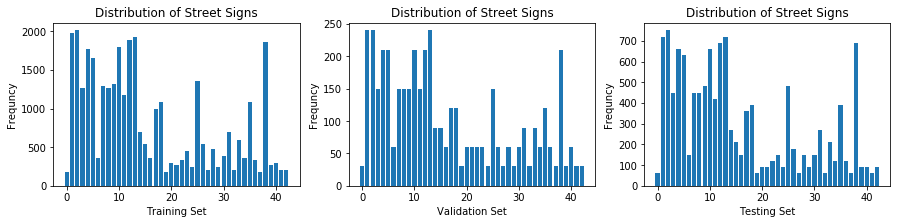

In [24]:
tsc.plotStats()

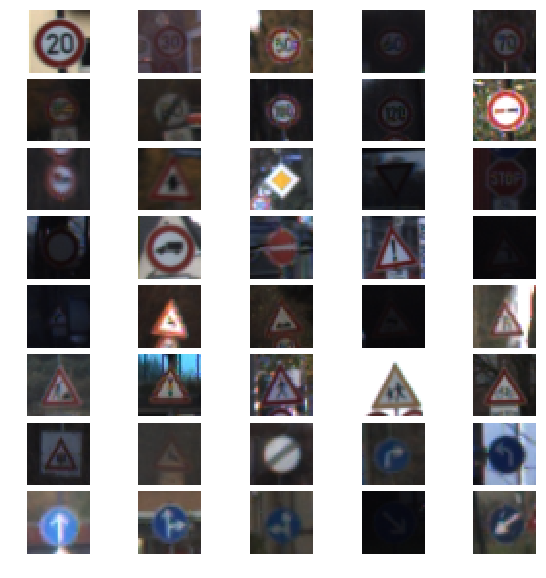

In [25]:
tsc.plotImages()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### 2.1 Preprocess Data

Preprossessing...
Finished Prepocessing.


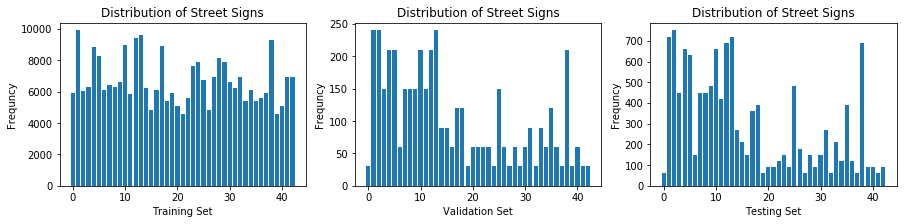

(288651, 32, 32, 1)


In [26]:
print("Preprossessing...")
tsc.preprocess(gray=True, norm=True)
tsc.plotStats()
print(tsc.X_train.shape)

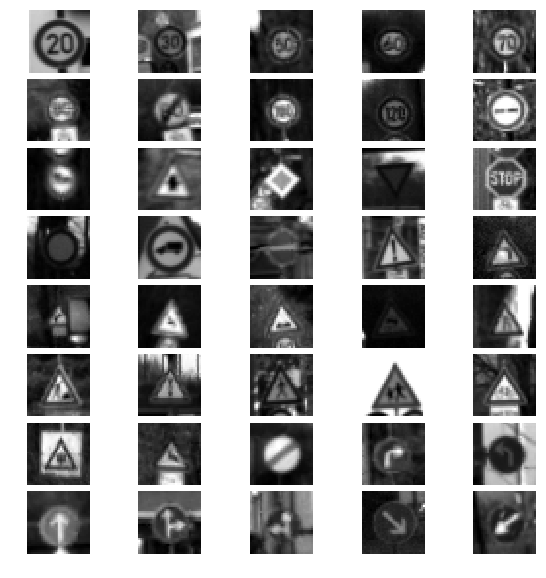

In [27]:
tsc.plotImages()

### 2.2 Train the Neural Network

Training...

EPOCH 01: Accuracy 0.900: Time: 00h:09m:05s
EPOCH 02: Accuracy 0.924: Time: 00h:09m:38s
EPOCH 03: Accuracy 0.932: Time: 00h:18m:18s
EPOCH 04: Accuracy 0.935: Time: 00h:18m:52s
EPOCH 05: Accuracy 0.937: Time: 00h:27m:31s
EPOCH 06: Accuracy 0.932: Time: 00h:28m:05s
EPOCH 07: Accuracy 0.938: Time: 00h:36m:46s
EPOCH 08: Accuracy 0.942: Time: 00h:37m:22s
EPOCH 09: Accuracy 0.943: Time: 00h:46m:02s
EPOCH 10: Accuracy 0.945: Time: 00h:46m:43s
EPOCH 11: Accuracy 0.941: Time: 00h:55m:21s
EPOCH 12: Accuracy 0.953: Time: 00h:56m:13s
EPOCH 13: Accuracy 0.953: Time: 01h:05m:30s
EPOCH 14: Accuracy 0.949: Time: 01h:06m:26s
EPOCH 15: Accuracy 0.951: Time: 01h:15m:44s
EPOCH 16: Accuracy 0.949: Time: 01h:16m:41s
EPOCH 17: Accuracy 0.948: Time: 01h:26m:00s
EPOCH 18: Accuracy 0.954: Time: 01h:26m:53s
EPOCH 19: Accuracy 0.956: Time: 01h:36m:14s
EPOCH 20: Accuracy 0.946: Time: 01h:37m:12s
EPOCH 21: Accuracy 0.951: Time: 01h:46m:33s
EPOCH 22: Accuracy 0.957: Time: 01h:47m:31s
EPOCH 23: Accuracy 

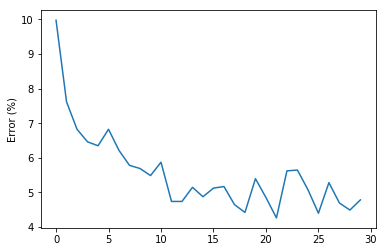

In [7]:
tsc.sigma  = 0.1
tsc.rate   = 0.0008
tsc.batch  = 128
tsc.epochs = 30
tsc.train()

### 2.3 Test the Neural Network

In [1]:
tsc.sigma  = 0.1
tsc.rate   = 0.0008
tsc.batch  = 128
tsc.epochs = 30
top_k = tsc.test(tsc.X_test, tsc.y_test)

Test Set Accuracy = 0.930


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

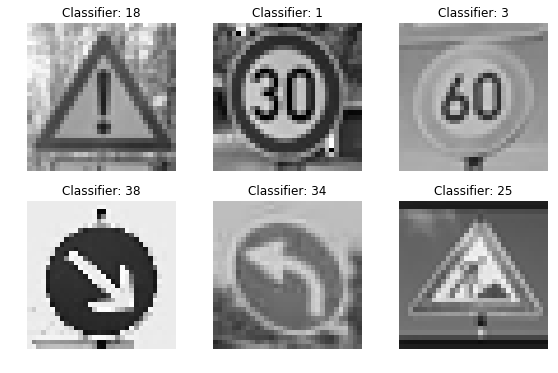

In [39]:
### Load Custom Sign Images.
#import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

%matplotlib inline

# Load Images from Directory.
signs = os.listdir('traffic_signs')

# Parse ID From Each.
data = np.zeros([len(signs), 32, 32, 3])
label = np.zeros([len(signs)]).astype(int)

fig, axs = plt.subplots(2,3, figsize=(10,6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i, image in enumerate(signs):
    
    # Load Image & Parse Title.
    data[i]  = cv2.imread('traffic_signs/' + image)
    label[i] = image.strip('.png')    
    
    # Plot Images.
    axs[i].axis('off')
    axs[i].imshow(data[i])
    axs[i].set_title("Classifier: {}".format(label[i]))
    
# Condition Image.
data = np.sum(data/6, axis=3, keepdims=True)
data = (data - 128) / 128

### Evaluate Test Images

In [12]:
top_k = tsc.test(data, label)

Test Set Accuracy = 0.833


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

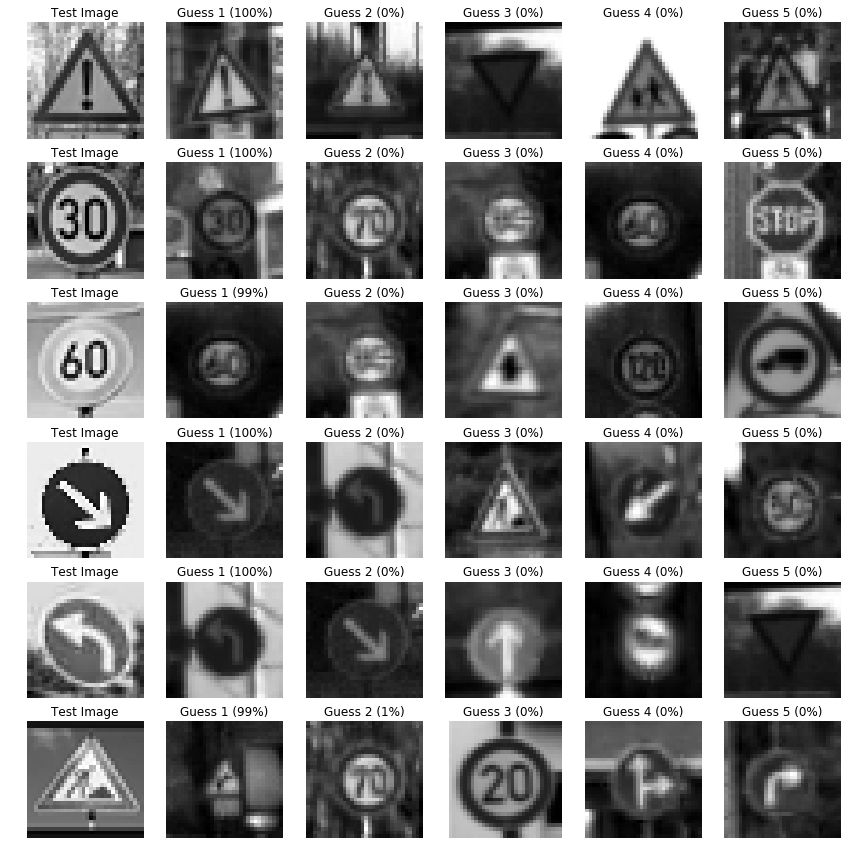

In [36]:
# Plot Top Five Predictions From Top_K.5
fig, axs = plt.subplots(6,6, figsize=(15,15))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in range(data.shape[0]):
    
    # Plot Images.
    axs[i*6].axis('off')
    axs[i*6].imshow(data[i].squeeze(), cmap='gray')
    axs[i*6].set_title("Test Image")
    
    # Cycle Through Predictions.
    predictions = top_k[1].shape
    for p in range(predictions[1]):
        axs[i*6+p+1].axis('off')
        
        axs[i*6+p+1].imshow(tsc.gallery[top_k[1][i][p]].squeeze(), cmap='gray')
        
        axs[i*6+p+1].set_title("Guess {} ({:0.0f}%)".format(p+1, top_k[0][i][p]*100))
